In [1]:
from packages.loaders import DataLoader
from notebooks.open_datasets.russian_inappropriate_messages.common import path_to_data, path_to_models
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout

train_x = DataLoader.load_numpy_array(path_to_data / 'perceptron' / "train_x_sparse_for_perceptron.npy")
train_y = DataLoader.load_numpy_array(path_to_data / 'perceptron' / "train_y_sparse_for_perceptron.npy")
test_x = DataLoader.load_numpy_array(path_to_data / 'perceptron' / "test_x_sparse_for_perceptron.npy")
test_y = DataLoader.load_numpy_array(path_to_data / 'perceptron' / "test_y_sparse_for_perceptron.npy")

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((99675,), (99675, 18), (24995,), (24995, 18))

In [2]:
train_y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [3]:
from scipy.sparse import vstack
import tensorflow as tf

test_x = vstack(test_x)
sparse_tensor_test = tf.sparse.SparseTensor(
    indices=list(zip(*test_x.nonzero())),  # индексы ненулевых элементов
    values=test_x.data,  # значения ненулевых элементов
    dense_shape=test_x.shape  # размерность разреженной матрицы
)
sparse_tensor_test = tf.sparse.reorder(sparse_tensor_test)

# Для сохранения объектов TensorFlow в файл обычно используется модуль tf.train,
# который позволяет сохранять данные в формате tfrecord. Однако, SparseTensor
# не может быть сохранен напрямую в tfrecord, так как он содержит как
# разреженные значения, так и индексы, которые являются целочисленными массивами переменной длины.
# Для сохранения SparseTensor в файл, его необходимо преобразовать к более удобному формату данных.
# Один из вариантов - сохранить значения, индексы и размеры в виде отдельных файлов, используя формат numpy.
# В связи с этим сохранять данный тензор нет смысла
sparse_tensor_test

SparseTensor(indices=tf.Tensor(
[[    0  5670]
 [    0 16076]
 [    0 28960]
 ...
 [24994 78463]
 [24994 87475]
 [24994 93143]], shape=(226589, 2), dtype=int64), values=tf.Tensor([0.52426934 0.28358857 0.35671268 ... 0.32530006 0.43398384 0.54190333], shape=(226589,), dtype=float64), dense_shape=tf.Tensor([24995 97260], shape=(2,), dtype=int64))

In [4]:
import time
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Input

train_x = vstack(train_x)
sparse_tensor_train = tf.sparse.SparseTensor(
    indices=list(zip(*train_x.nonzero())),  # индексы ненулевых элементов
    values=train_x.data,  # значения ненулевых элементов
    dense_shape=train_x.shape  # размерность разреженной матрицы
)
sparse_tensor_train = tf.sparse.reorder(sparse_tensor_train)

INPUT_SHAPE = train_x.shape[1]
OUTPUT_SHAPE = train_y.shape[1]

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=7, restore_best_weights=True)

In [15]:
start = time.time()

model = Sequential()

model.add(Input(shape=(INPUT_SHAPE,), sparse=True))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(OUTPUT_SHAPE, activation='softmax'))

optimizer  = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

history_training = model.fit(sparse_tensor_train, train_y, epochs=50, batch_size=5, callbacks=[early_stop], validation_data=(sparse_tensor_test, test_y), workers=-1)

total_pred_time = time.time() - start
print(total_pred_time)

Epoch 1/50
19935/19935 [==============================] - 2775s 139ms/step - loss: 2.8588 - accuracy: 0.0867 - val_loss: 2.8298 - val_accuracy: 0.1063
Epoch 2/50
19935/19935 [==============================] - 2813s 141ms/step - loss: 2.8501 - accuracy: 0.0902 - val_loss: 2.7739 - val_accuracy: 0.1077
Epoch 3/50
19935/19935 [==============================] - 2853s 143ms/step - loss: 2.8328 - accuracy: 0.0948 - val_loss: 2.7685 - val_accuracy: 0.0970
Epoch 4/50
19935/19935 [==============================] - 2839s 142ms/step - loss: 2.8043 - accuracy: 0.0963 - val_loss: 2.7192 - val_accuracy: 0.1308
Epoch 5/50
19935/19935 [==============================] - 2848s 143ms/step - loss: 2.8109 - accuracy: 0.0995 - val_loss: 2.7348 - val_accuracy: 0.1084
Epoch 6/50
19935/19935 [==============================] - 2791s 140ms/step - loss: 2.8018 - accuracy: 0.0999 - val_loss: 2.6840 - val_accuracy: 0.1191
Epoch 7/50
19935/19935 [==============================] - 2244s 113ms/step - loss: 2.8066 - ac

In [6]:
start = time.time()

model_2 = Sequential()

model_2.add(Input(shape=(INPUT_SHAPE,), sparse=True))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Dense(OUTPUT_SHAPE, activation='softmax'))

optimizer  = Adam(learning_rate=0.01)
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

history_training_2 = model_2.fit(sparse_tensor_train, train_y, epochs=100, batch_size=5, callbacks=[early_stop], validation_data=(sparse_tensor_test, test_y), workers=-1)

total_pred_time = time.time() - start
print(total_pred_time)

Epoch 1/100
19935/19935 [==============================] - 1174s 59ms/step - loss: 2.3780 - accuracy: 0.2832 - val_loss: 1.8764 - val_accuracy: 0.4490
Epoch 2/100
19935/19935 [==============================] - 1474s 74ms/step - loss: 2.0488 - accuracy: 0.3881 - val_loss: 1.7511 - val_accuracy: 0.5038
Epoch 3/100
19935/19935 [==============================] - 1476s 74ms/step - loss: 1.9256 - accuracy: 0.4280 - val_loss: 1.7254 - val_accuracy: 0.5177
Epoch 4/100
19935/19935 [==============================] - 1475s 74ms/step - loss: 1.8531 - accuracy: 0.4515 - val_loss: 1.7092 - val_accuracy: 0.5229
Epoch 5/100
19935/19935 [==============================] - 1482s 74ms/step - loss: 1.8200 - accuracy: 0.4602 - val_loss: 1.8128 - val_accuracy: 0.5100
Epoch 6/100
19935/19935 [==============================] - 1476s 74ms/step - loss: 1.8055 - accuracy: 0.4666 - val_loss: 1.8150 - val_accuracy: 0.5112
Epoch 7/100
19935/19935 [==============================] - 1481s 74ms/step - loss: 1.7613 - ac

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

def draw_plot(data, type_data):
    plt.figure(figsize=(25, 5))
    plt.plot(data, 'darkorange', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel(type_data)
    plt.legend()


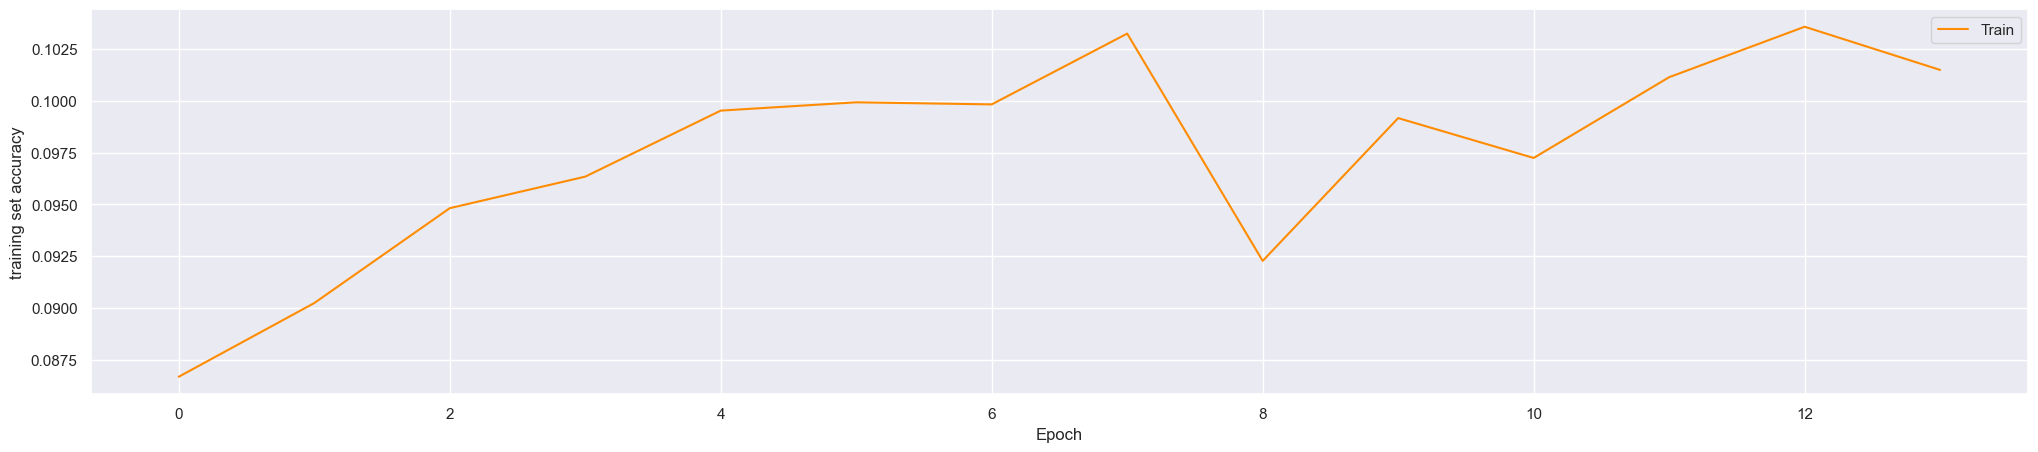

In [17]:
draw_plot(history_training.history['accuracy'], 'training set accuracy')

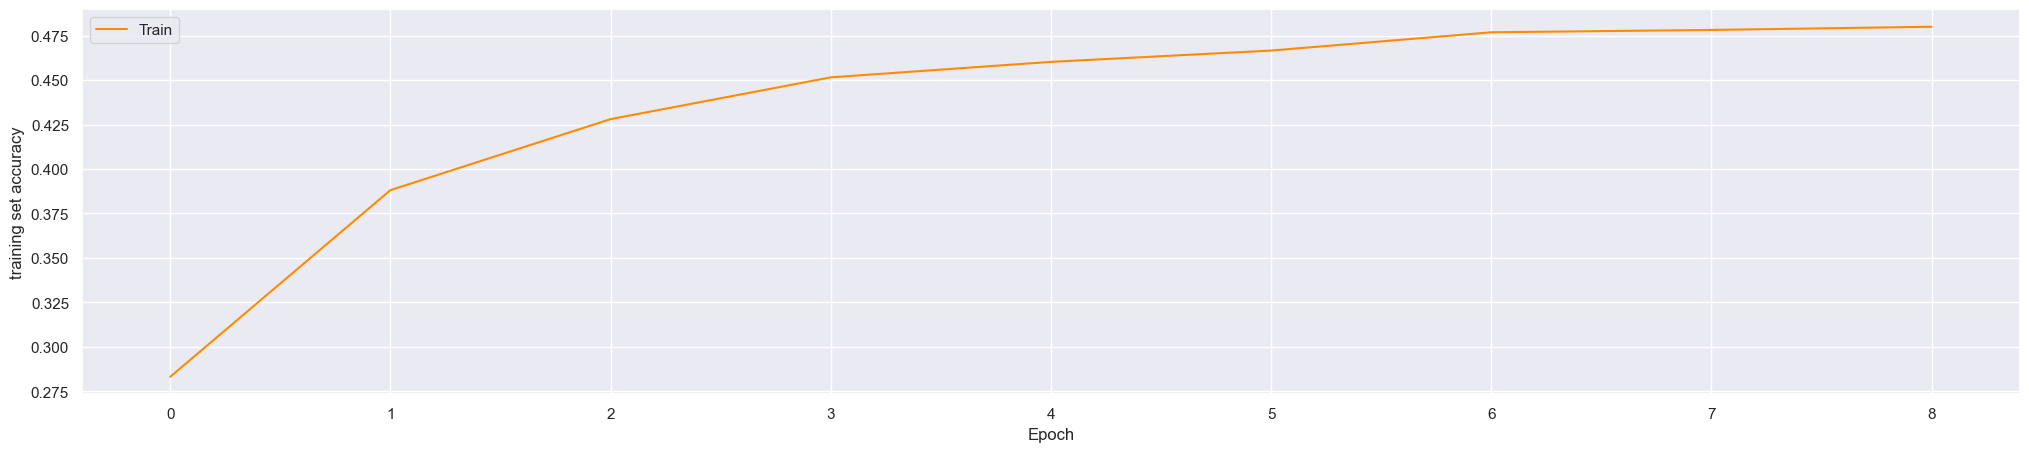

In [8]:
draw_plot(history_training_2.history['accuracy'], 'training set accuracy')

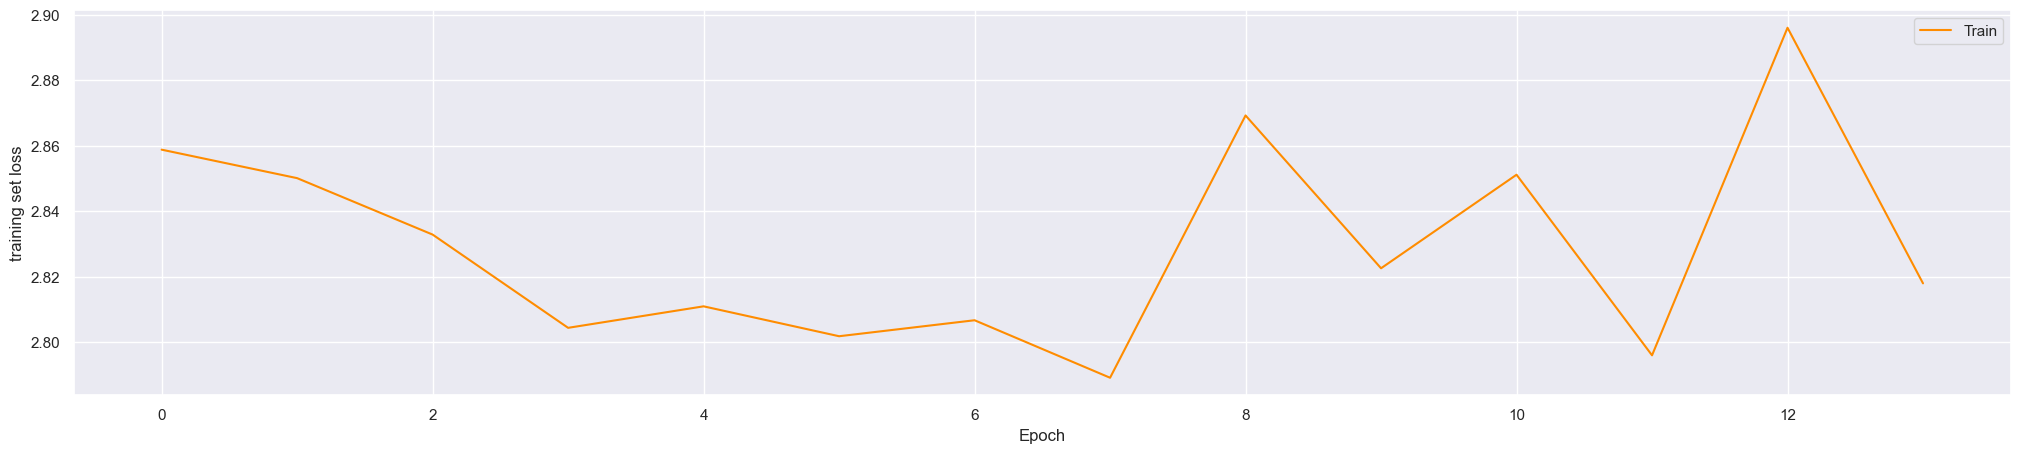

In [16]:
draw_plot(history_training.history['loss'], 'training set loss')

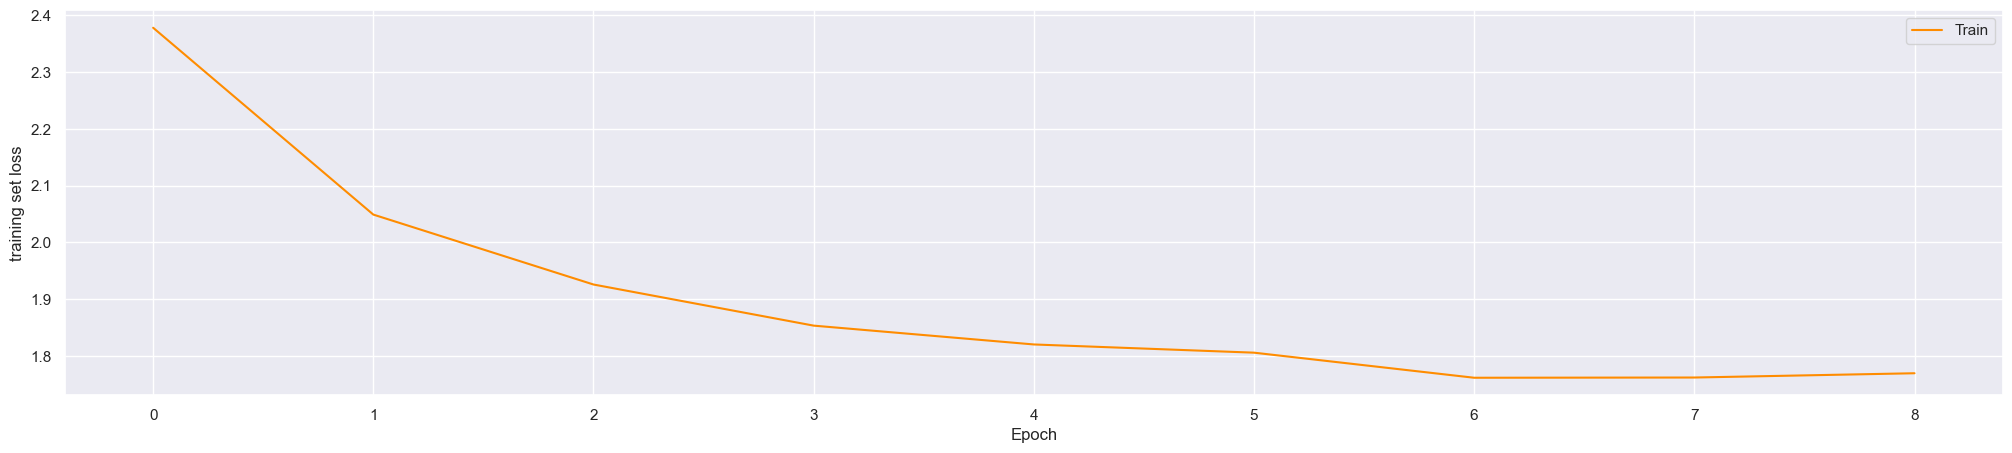

In [9]:
draw_plot(history_training_2.history['loss'], 'training set loss')

In [18]:
# model.save(path_to_models / "perceptron" / "perceptron.h5")

In [10]:
# model_2.save(path_to_models / "perceptron" / "perceptron_2.h5")

In [11]:
start = time.time()

model_3 = Sequential()

model_3.add(Input(shape=(INPUT_SHAPE,), sparse=True))
model_3.add(Dense(128, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.4))
model_3.add(Dense(64, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.4))
model_3.add(Dense(OUTPUT_SHAPE, activation='softmax'))

optimizer  = Adam(learning_rate=0.01)
model_3.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

history_training_3 = model_3.fit(sparse_tensor_train, train_y, epochs=100, batch_size=25, callbacks=[early_stop], validation_data=(sparse_tensor_test, test_y))

total_pred_time = time.time() - start
print(total_pred_time)

Epoch 1/100
3987/3987 [==============================] - 299s 75ms/step - loss: 1.6881 - accuracy: 0.5153 - val_loss: 1.1949 - val_accuracy: 0.6539
Epoch 2/100
3987/3987 [==============================] - 297s 74ms/step - loss: 0.9172 - accuracy: 0.7344 - val_loss: 1.1559 - val_accuracy: 0.6729
Epoch 3/100
3987/3987 [==============================] - 295s 74ms/step - loss: 0.6544 - accuracy: 0.8100 - val_loss: 1.2053 - val_accuracy: 0.6778
Epoch 4/100
3987/3987 [==============================] - 304s 76ms/step - loss: 0.5192 - accuracy: 0.8477 - val_loss: 1.3171 - val_accuracy: 0.6751
Epoch 5/100
3987/3987 [==============================] - 325s 82ms/step - loss: 0.4307 - accuracy: 0.8736 - val_loss: 1.4047 - val_accuracy: 0.6740
Epoch 6/100
3987/3987 [==============================] - 311s 78ms/step - loss: 0.3765 - accuracy: 0.8892 - val_loss: 1.4405 - val_accuracy: 0.6702
Epoch 7/100
3987/3987 [==============================] - 295s 74ms/step - loss: 0.3384 - accuracy: 0.8992 - val_

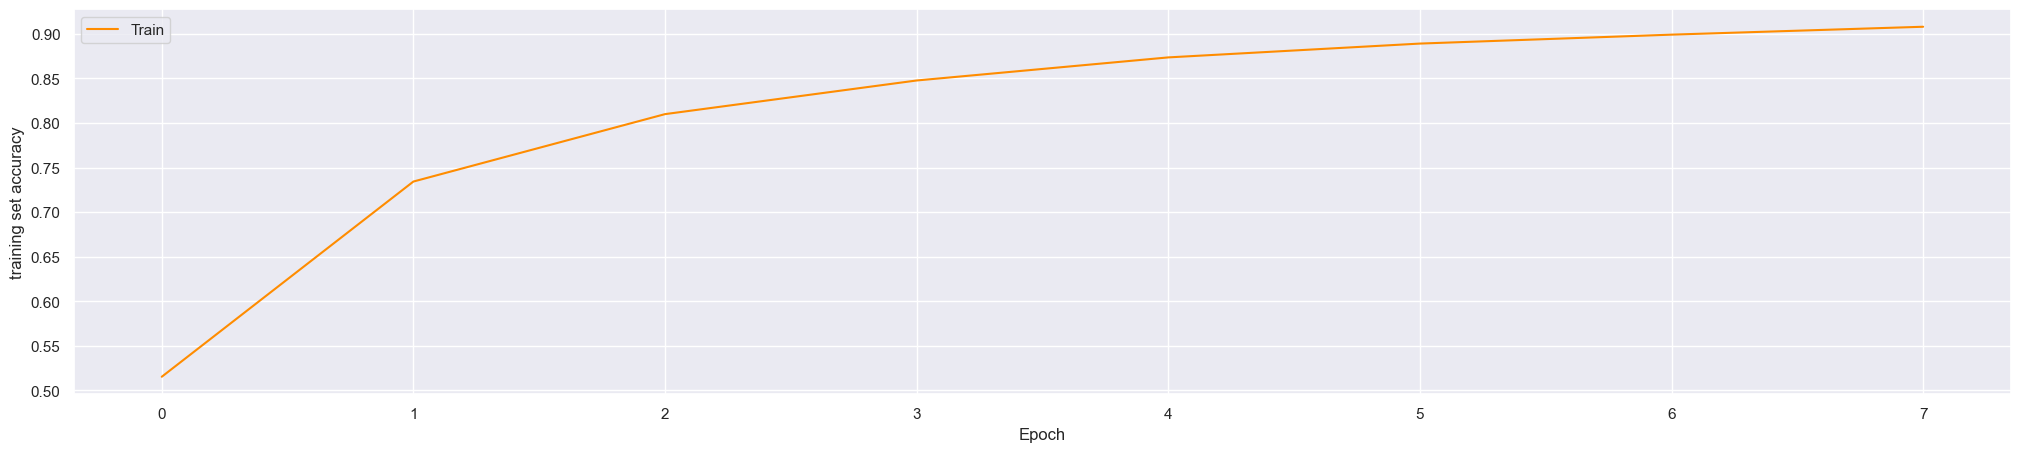

In [12]:
draw_plot(history_training_3.history['accuracy'], 'training set accuracy')

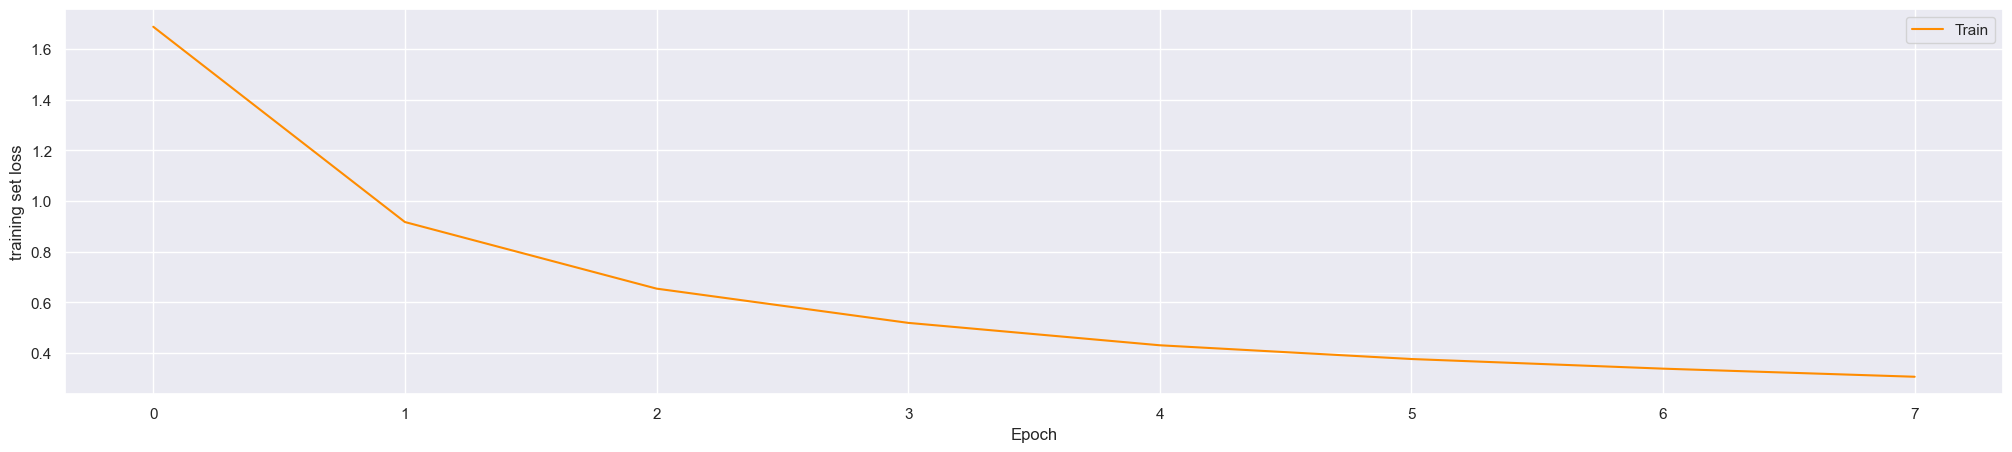

In [13]:
draw_plot(history_training_3.history['loss'], 'training set loss')

In [14]:
# model_3.save(path_to_models / "perceptron" / "perceptron_3.h5")

In [6]:
from keras.optimizers import SGD


start = time.time()

model_4 = Sequential()

model_4.add(Input(shape=(INPUT_SHAPE,), sparse=True))
model_4.add(Dense(256, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))
model_4.add(Dense(64, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))
model_4.add(Dense(OUTPUT_SHAPE, activation='softmax'))

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True)
optimizer  = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# optimizer  = Adam(learning_rate=0.01)
model_4.compile(loss='categorical_crossentropy', optimizer=optimizer , metrics=['accuracy'])

history_training_4 = model_4.fit(sparse_tensor_train, train_y, epochs=100, batch_size=25, callbacks=[early_stop], validation_data=(sparse_tensor_test, test_y))

total_pred_time = time.time() - start
print(total_pred_time)

Epoch 1/100
3987/3987 [==============================] - 12s 3ms/step - loss: 1.7940 - accuracy: 0.4832 - val_loss: 1.2553 - val_accuracy: 0.6399
Epoch 2/100
3987/3987 [==============================] - 11s 3ms/step - loss: 1.1997 - accuracy: 0.6547 - val_loss: 1.1474 - val_accuracy: 0.6674
Epoch 3/100
3987/3987 [==============================] - 11s 3ms/step - loss: 0.9876 - accuracy: 0.7123 - val_loss: 1.1285 - val_accuracy: 0.6774
Epoch 4/100
3987/3987 [==============================] - 13s 3ms/step - loss: 0.8372 - accuracy: 0.7525 - val_loss: 1.1479 - val_accuracy: 0.6787
Epoch 5/100
3987/3987 [==============================] - 13s 3ms/step - loss: 0.7302 - accuracy: 0.7826 - val_loss: 1.1902 - val_accuracy: 0.6782
Epoch 6/100
3987/3987 [==============================] - 28s 7ms/step - loss: 0.6494 - accuracy: 0.8065 - val_loss: 1.2202 - val_accuracy: 0.6782
Epoch 7/100
3987/3987 [==============================] - 13s 3ms/step - loss: 0.5810 - accuracy: 0.8267 - val_loss: 1.2469 -

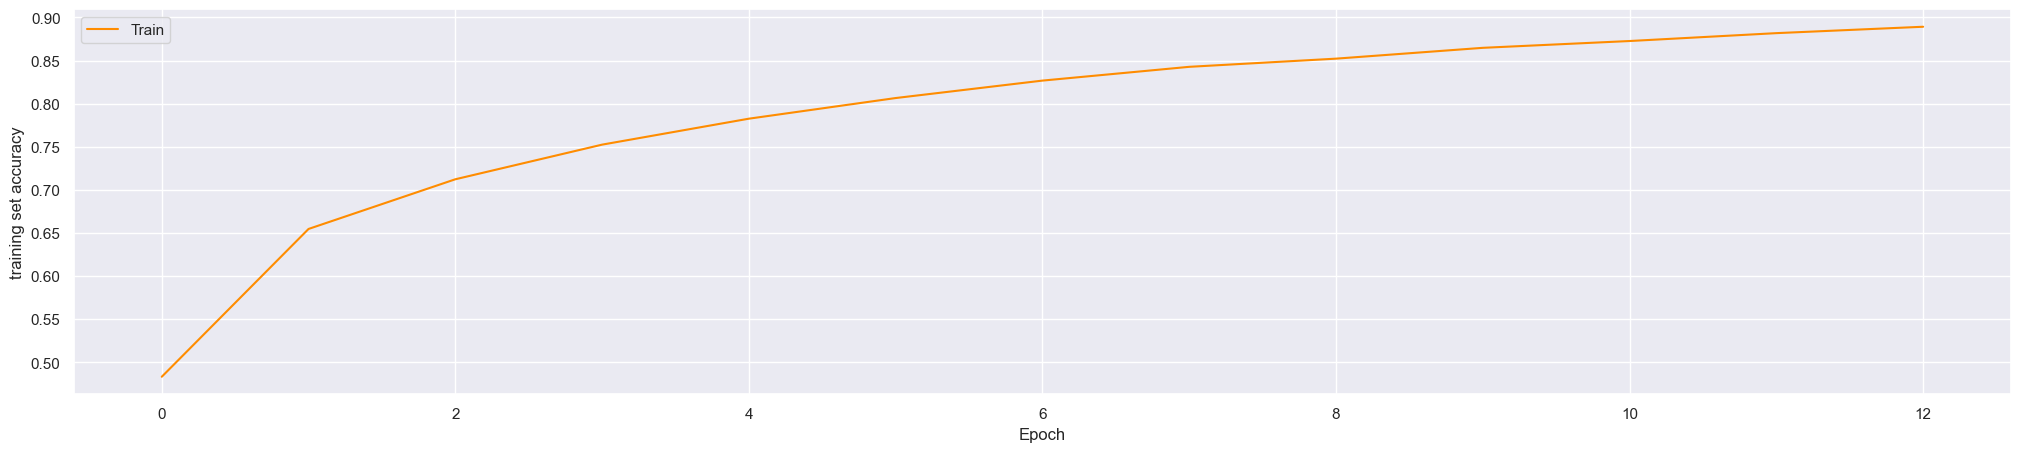

In [7]:
draw_plot(history_training_4.history['accuracy'], 'training set accuracy')

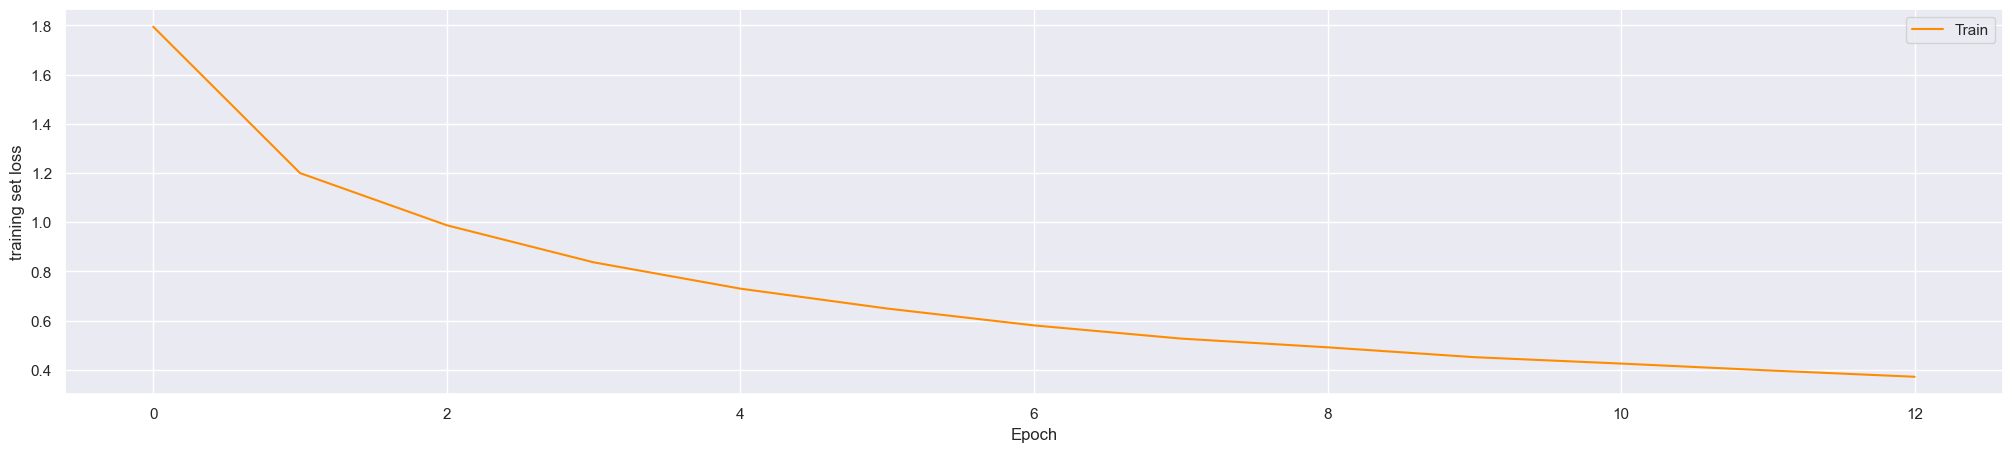

In [8]:
draw_plot(history_training_4.history['loss'], 'training set loss')

In [9]:
model_4.save(path_to_models / "perceptron" / "perceptron_4.h5")